In [1]:
library(ggplot2)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
cells <- read_csv("../../data/JoanitoData/NonEpithelial_metadata.csv")
cells %>% head

Rows: 323903 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): cell.ID, sample.ID, patient.ID, sample.origin, dataset, cell.type
dbl (3): nCount_RNA, nFeature_RNA, percent.mt

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cell.ID,nCount_RNA,nFeature_RNA,percent.mt,sample.ID,patient.ID,sample.origin,dataset,cell.type
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
CRC16_MUX8563_AAACCTGCAAGCCGCT-1,29514,2577,1.2359316,MUX8563,CRC2794,Tumor,CRC-SG1,PlasmaB
CRC16_MUX8563_AAACCTGTCTCGATGA-1,3259,1531,6.1718900,MUX8563,CRC2794,Tumor,CRC-SG1,T_NK
CRC16_MUX8563_AAACCTGTCTCTGTCG-1,71212,3083,0.8918498,MUX8563,CRC2794,Tumor,CRC-SG1,PlasmaB
CRC16_MUX8563_AAACGGGCAAGTTAAG-1,3771,1686,3.6399148,MUX8563,CRC2794,Tumor,CRC-SG1,T_NK
CRC16_MUX8563_AAACGGGCAGTTCATG-1,16948,4304,3.9754246,MUX8563,CRC2794,Tumor,CRC-SG1,Fibroblast
CRC16_MUX8563_AAAGATGAGTTAACGA-1,7321,3080,6.7545305,MUX8563,CRC2794,Tumor,CRC-SG1,Fibroblast


In [3]:
patients <- read_csv("../../data/JoanitoData/patient_clinical_information.csv")
patients %>% head

Rows: 63 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): dataset, patient.ID, Gender, MSS/MSI, Site, Sidedness, Group Stage...
dbl  (4): Age at recruitment, LymphNode, Normal, Tumor

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


dataset,patient.ID,Gender,Age at recruitment,MSS/MSI,Site,Sidedness,Group Stage,Stage TNM,iCMS.transcriptomic,iCMS.inferCNV,KRAS,BRAF,TP53,APC,PIK3CA,LymphNode,Normal,Tumor,CMS
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
CRC-SG2,CRC-JSC-S02,M,47,MSI-H,Caecum,R,3,pT1N1(1/65 - ileocolic node)M0,iCMS3,iCMS3,wt,wt,wt,mut,wt,0,0,3,CMS3
CRC-SG2,CRC-JSC-S03,F,59,MSI-H,Ascending colon,R,2,T3N0M0,iCMS3,iCMS3,wt,wt,wt,wt,mut,0,0,4,CMS3
CRC-SG2,CRC-JSC-S04,F,65,MSS,Distal Sigmoid colon,L,3,T4bN2aM0,iCMS2,iCMS2,wt,wt,mut,mut,wt,0,0,2,NA
CRC-SG2,CRC-JSC-S05,M,79,MSI-H,Caecum,R,2,mpT3N0M0,iCMS3,iCMS3,mut,mut,mut,wt,mut,0,0,2,CMS3
CRC-SG2,CRC-JSC-S06,M,80,MSS,Rectum,L,3,T4aN1M0,iCMS2,iCMS2,mut,wt,mut,mut,wt,0,0,2,NA
CRC-SG2,CRC-JSC-S07,M,66,MSS,Rectosigmoid,L,2,T3N0M0,iCMS2,iCMS2,wt,wt,mut,mut,wt,0,0,2,CMS2


In [4]:
patients$T_stage <- str_extract(patients$`Stage TNM`, "T(\\d)") %>% 
  str_remove("T") %>% 
  as.numeric()
table(patients$T_stage)


 1  2  3  4 
 3  3 38 19 

In [5]:
patients$N_stage <- str_extract(patients$`Stage TNM`, "N(\\d)") %>% 
  str_remove("N") %>% 
  as.numeric()
table(patients$N_stage)


 0  1  2 
24 31  8 

In [6]:
# Merge both dataframes based on `patient.ID` and `dataset`
grouping_vars <- c("patient.ID", "dataset", "T_stage", "N_stage", "CMS","MSS/MSI", "cell.type")
merged_data <- cells %>%
    inner_join(patients, by = c("patient.ID", "dataset")) %>%
    select(all_of(grouping_vars))

# Sum up cell types by patient.ID and dataset
summarized_data <- merged_data %>%
  group_by(patient.ID, dataset, cell.type) %>%
  summarise(
    count = n(),
    T_stage = first(T_stage),
    N_stage = first(N_stage),
    CMS = first(CMS),
    `MSS/MSI` = first(`MSS/MSI`)
  ) %>%
  ungroup()

`summarise()` has grouped output by 'patient.ID', 'dataset'. You can override
using the `.groups` argument.


In [7]:
unique(merged_data$cell.type)

[1] "PlasmaB"      "T_NK"         "Fibroblast"   "McDC"         "Endothelial" 
 [6] "B"            "Neutrophils"  "Mast"         "pDC"          "Entericglial"

In [8]:
# 1. Compute the proportion of each cell type per (patient.ID, dataset) pair
proportion_data <- summarized_data %>%
  group_by(patient.ID, dataset) %>%
  mutate(proportion = count / sum(count)) %>%
  ungroup()

# 2. Add a small non-zero component to zero proportions
min_nonzero <- min(proportion_data$proportion[proportion_data$proportion > 0])
proportion_data <- proportion_data %>%
  mutate(proportion_nozero = ifelse(proportion == 0, min_nonzero / 10, proportion))

# 3. Reshape to wide format for CLR
proportion_wide <- proportion_data %>%
  select(patient.ID, dataset, cell.type, proportion_nozero) %>%
  pivot_wider(names_from = cell.type, values_from = proportion_nozero, values_fill = min_nonzero / 10)

# 4. CLR transformation without extra libraries
clr_transform <- function(mat) {
  log_mat <- log(mat)
  gm <- rowMeans(log_mat)
  sweep(log_mat, 1, gm)
}

clr_matrix <- proportion_wide %>%
  select(-patient.ID, -dataset) %>%
  as.matrix() %>%
  clr_transform()

# 5. Assemble into a long data frame for plotting
clr_df <- proportion_wide %>%
  select(patient.ID, dataset) %>%
  bind_cols(as_tibble(clr_matrix)) %>%
  pivot_longer(
    cols = -c(patient.ID, dataset),
    names_to = "cell_type",
    values_to = "clr_value"
  ) %>%
  left_join(
    patients %>% select(patient.ID, dataset, T_stage, N_stage, CMS, `MSS/MSI`),
    by = c("patient.ID", "dataset")
  )

# 6. Exclude uninterpretable cell types
excluded_types <- c('Fibroblast', 'Endothelial', 'Entericglial')
clr_df <- clr_df %>% filter(!cell_type %in% excluded_types)

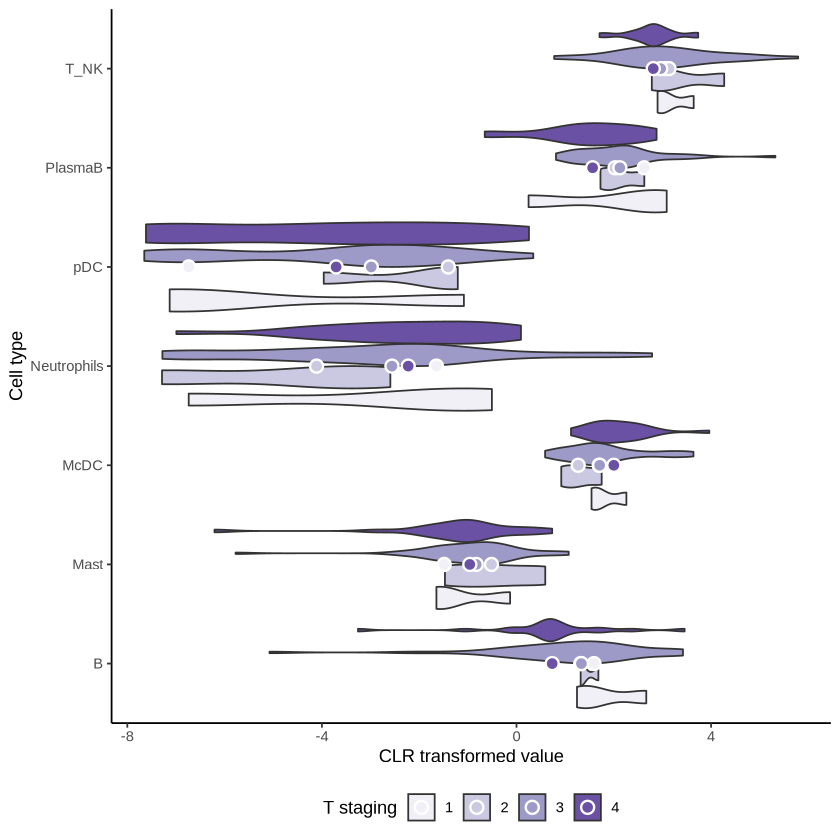

In [14]:
# 7. Violin plot
gp <- ggplot(clr_df, aes(x = cell_type, y = clr_value, fill = as.factor(T_stage))) +
  geom_violin(scale = "width") +
  stat_summary(
    fun = median, 
    geom = "point", 
    shape = 21,                               # filled circle with outline
    color = "white",                          # outline color
    size = 3, 
    stroke = 1                                # outline thickness
  ) +
  coord_flip() +
  theme_classic() +
  scale_fill_brewer(palette = "Purples") +
  labs(x = "Cell type", y = "CLR transformed value", fill = "T staging") +
  theme(legend.position = "bottom")

ggsave("../../figures/fig6/clr_violin_pt.pdf", gp, width = 5, height = 5)
gp

In [10]:
# For each cell type, test association between CLR value and T_stage
cell_types <- unique(clr_df$cell_type)
p_values <- numeric(length(cell_types))

for (i in seq_along(cell_types)) {
  df_sub <- clr_df %>% filter(cell_type == cell_types[i])
  # Remove NA T_stage if any
  df_sub <- df_sub %>% filter(!is.na(T_stage))
  # Kendall's tau test
  test <- cor.test(df_sub$clr_value, df_sub$T_stage, method = "kendall")
  p_values[i] <- test$p.value
}

# FDR correction (Benjamini-Hochberg)
p_values_corrected <- p.adjust(p_values, method = "BH")

# Print results
for (i in seq_along(cell_types)) {
  cat(sprintf("Cell type: %s, FDR: %.4g\n", cell_types[i], p_values_corrected[i]))
}

Cell type: B, FDR: 0.1301
Cell type: Mast, FDR: 0.4929
Cell type: McDC, FDR: 0.1301
Cell type: Neutrophils, FDR: 0.3298
Cell type: PlasmaB, FDR: 0.1301
Cell type: T_NK, FDR: 0.1723
Cell type: pDC, FDR: 0.5509


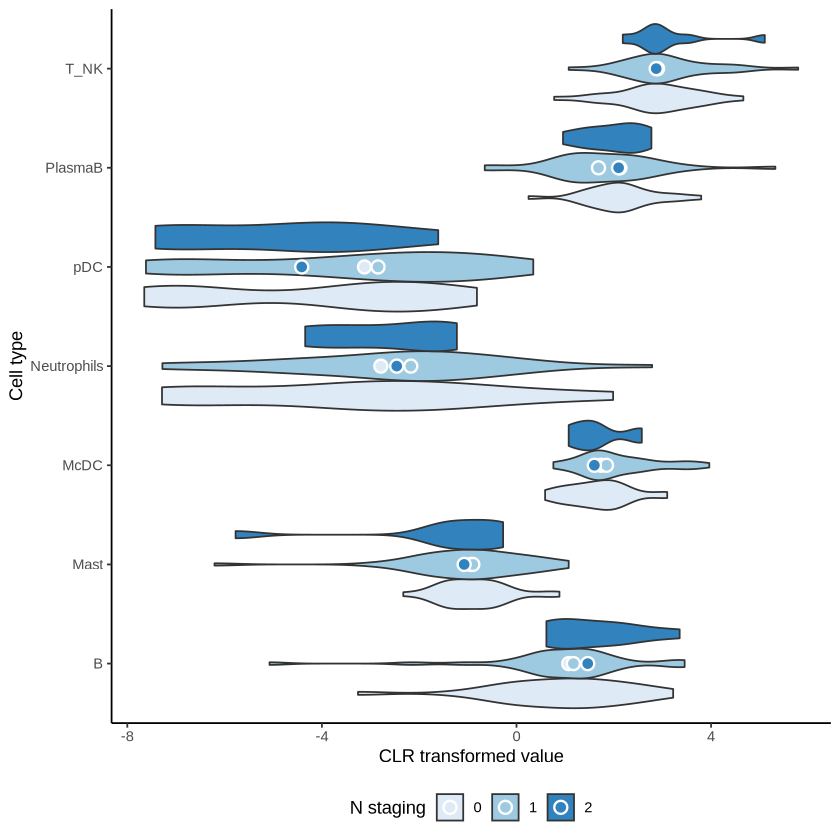

In [11]:
gp_n <- ggplot(clr_df, aes(x = cell_type, y = clr_value, fill = as.factor(N_stage))) +
  geom_violin(scale = "width") +
  stat_summary(
    fun = median,
    geom = "point",
    shape = 21,
    color = "white",
    size = 3,
    stroke = 1
  ) +
  coord_flip() +
  theme_classic() +
  scale_fill_brewer(palette = "Blues") +
  labs(x = "Cell type", y = "CLR transformed value", fill = "N staging") +
  theme(legend.position = "bottom")
gp_n

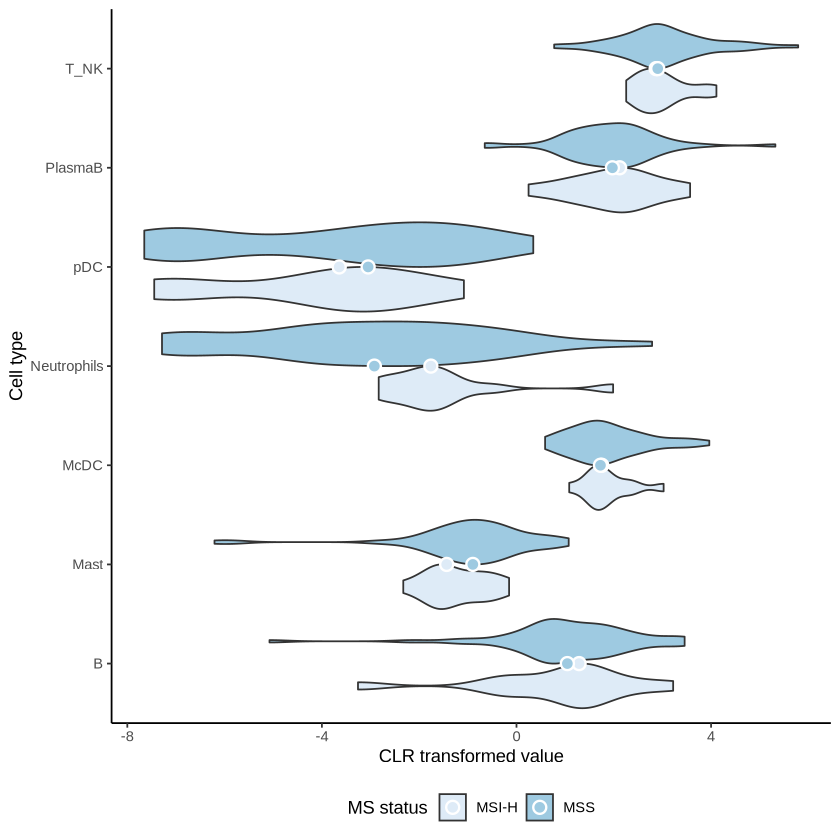

In [12]:
gp_m <- ggplot(clr_df, aes(x = cell_type, y = clr_value, fill = as.factor(`MSS/MSI`))) +
  geom_violin(scale = "width") +
  stat_summary(
    fun = median,
    geom = "point",
    shape = 21,
    color = "white",
    size = 3,
    stroke = 1
  ) +
  coord_flip() +
  theme_classic() +
  scale_fill_brewer(palette = "Blues") +
  labs(x = "Cell type", y = "CLR transformed value", fill = "MS status") +
  theme(legend.position = "bottom")
gp_m

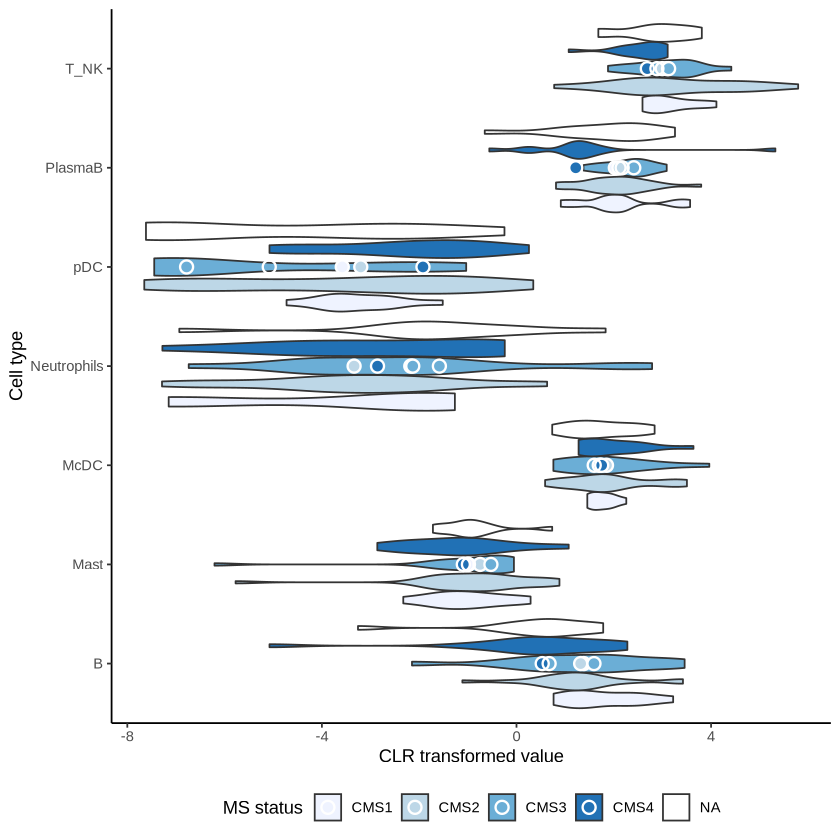

In [13]:
gp_c <- ggplot(clr_df, aes(x = cell_type, y = clr_value, fill = as.factor(CMS))) +
  geom_violin(scale = "width") +
  stat_summary(
    fun = median,
    geom = "point",
    shape = 21,
    color = "white",
    size = 3,
    stroke = 1
  ) +
  coord_flip() +
  theme_classic() +
  scale_fill_brewer(palette = "Blues") +
  labs(x = "Cell type", y = "CLR transformed value", fill = "MS status") +
  theme(legend.position = "bottom")
gp_c